In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d trolukovich/food11-image-dataset
!unzip food11-image-dataset.zip -d /content/food11


Streaming output truncated to the last 5000 lines.
  inflating: /content/food11/training/Soup/223.jpg  
  inflating: /content/food11/training/Soup/224.jpg  
  inflating: /content/food11/training/Soup/225.jpg  
  inflating: /content/food11/training/Soup/226.jpg  
  inflating: /content/food11/training/Soup/227.jpg  
  inflating: /content/food11/training/Soup/228.jpg  
  inflating: /content/food11/training/Soup/229.jpg  
  inflating: /content/food11/training/Soup/23.jpg  
  inflating: /content/food11/training/Soup/230.jpg  
  inflating: /content/food11/training/Soup/231.jpg  
  inflating: /content/food11/training/Soup/232.jpg  
  inflating: /content/food11/training/Soup/233.jpg  
  inflating: /content/food11/training/Soup/234.jpg  
  inflating: /content/food11/training/Soup/235.jpg  
  inflating: /content/food11/training/Soup/236.jpg  
  inflating: /content/food11/training/Soup/237.jpg  
  inflating: /content/food11/training/Soup/238.jpg  
  inflating: /content/food11/training/Soup/239.jp

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20
)

# Validation / Testing data (only rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    '/content/food11/validation',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation generator
val_generator = test_datagen.flow_from_directory(
    '/content/food11/evaluation',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    '/content/food11/training',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.
Found 9866 images belonging to 11 classes.


In [ ]:
!pip install tensorflow tensorflow_hub matplotlib

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

In [ ]:
img_size = 224
batch_size = 32


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/food11/training',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    '/content/food11/validation',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/food11/evaluation',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model

# Input
inputs = Input(shape=(img_size, img_size, 3))

# Wrap hub.KerasLayer in Lambda
x = Lambda(lambda x: hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
    trainable=False
)(x))(inputs)

# Dropout + Dense
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# Model
model = Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │        14,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,091 (55.04 KB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 172s 500ms/step - accuracy: 0.5282 - loss: 1.4173 - val_accuracy: 0.7857 - val_loss: 0.6278
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 142s 458ms/step - accuracy: 0.7791 - loss: 0.6507 - val_accuracy: 0.8055 - val_loss: 0.5733
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 141s 455ms/step - accuracy: 0.8053 - loss: 0.5851 - val_accuracy: 0.8181 - val_loss: 0.5389
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 140s 452ms/step - accuracy: 0.8205 - loss: 0.5388 - val_accuracy: 0.8207 - val_loss: 0.5312
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 140s 452ms/step - accuracy: 0.8311 - loss: 0.5036 - val_accuracy: 0.8271 - val_loss: 0.5160
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 140s 453ms/step - accuracy: 0.8320 - loss: 0.4942 - val_accuracy: 0.8222 - val_loss: 0.5288
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 140s 452ms/step - accuracy: 0.8265 - loss: 0.5106 - val_accuracy: 0.8344 - val_loss: 0.4966
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 147s 474ms/step - accuracy: 0.8385 -

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.7912 - loss: 0.6162
Test Accuracy: 85.36%


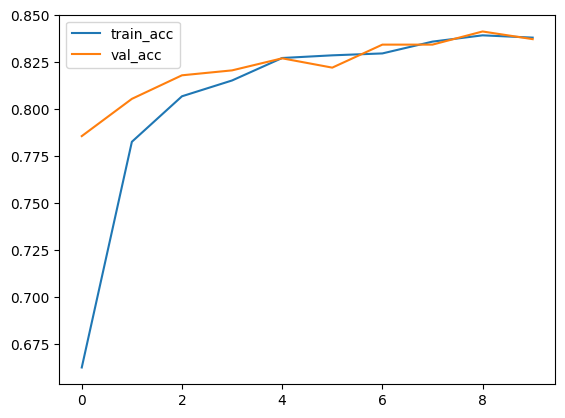

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [ ]:
calorie_dict = {
    'Bread': 80,
    'Dairy products': 150,
    'Dessert': 250,
    'Egg': 70,
    'Fried food': 300,
    'Meat': 250,
    'Noodles/Pasta': 220,
    'Rice': 200,
    'Seafood': 180,
    'Soup': 100,
    'Vegetable/Fruit': 50
}

def predict_food(img_path):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    x = image.img_to_array(img)/255.0
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    class_idx = np.argmax(preds)
    class_name = list(train_generator.class_indices.keys())[class_idx]
    calories = calorie_dict.get(class_name, "Unknown")
    return class_name, calories

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


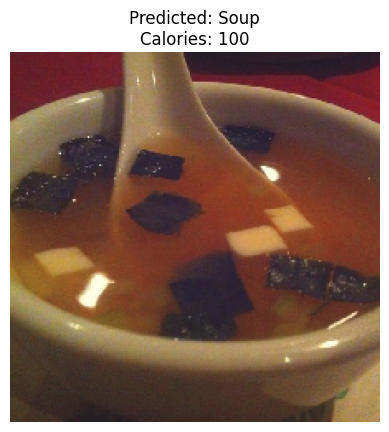

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing import image


test_dir = '/content/food11/evaluation'


def show_random_predictions(num_images=1):

    class_folders = [os.path.join(test_dir, cls) for cls in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, cls))]

    for _ in range(num_images):

        cls_folder = random.choice(class_folders)

        img_file = random.choice(os.listdir(cls_folder))
        img_path = os.path.join(cls_folder, img_file)


        img = image.load_img(img_path, target_size=(img_size, img_size))
        x = image.img_to_array(img)/255.0
        x = np.expand_dims(x, axis=0)


        preds = model.predict(x)
        class_idx = np.argmax(preds)
        class_name = list(train_generator.class_indices.keys())[class_idx]
        calories = calorie_dict.get(class_name, "Unknown")


        plt.imshow(img)
        plt.title(f"Predicted: {class_name}\nCalories: {calories}")
        plt.axis('off')
        plt.show()


show_random_predictions(num_images=1)
